In [1]:
# serial number of PASTTREC, needs to be edit for each PASTTREC tested: 
serial = "0001"
#----- default settings for the mass test, don't change:
measure_board_list=[ "4000"]
# threshold scan scurve fit quality limit to store results
chisquare_limit = 50
# PASTTREC ASIC parameters:
pt_pktime = 15
pt_gain = 4
pt_threshold_default = 20

data_output_dicrectory="/workdir/data/pasttrec_quality"


In [2]:
#%matplotlib notebook  
from matplotlib import pyplot as plt
import numpy as np
import pasttrec_ctrl as ptc
import json
import sigproc_kit
import tdc_daq as td
import baseline_calib
import ROOT
import db
from cw_pasttrec_functions import *

from my_utils import *
set_width_max_of_jupyterpad()

    
def hist_rms(x,y):
  counts = np.sum(y)
  weights = y / counts
  mean = np.dot(x,weights)
  deviations = x - mean
  return np.sqrt(np.dot(deviations**2,weights))
def list_rms(x):
  mean = sum(x)/len(x)
  deviations =  np.asarray(x) -  np.asarray(mean)
  return np.sqrt(sum(deviations**2) /len(x))
def MeanArrays(xs,ys):
    return np.dot(xs,ys)/sum(ys)
def fwhm(x,y):
  dummy, t1, tot = sigproc_kit.discriminate(x,y,np.max(y)/2.,0,0)
  return tot
import os
#pulse generator, set up pulse shape
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3AOUTPUT2%20ON'")
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3ASOUR2%3AFREQ%201500'")
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3ASOUR2%3AVOLT%3ALEV%3AHIGH%202500mV'")
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3ASOUR2%3AVOLT%3ALEV%3ALOW%200mV'")
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3ASOUR2%3AVOLT%3ALEV%3AOFFS%200mV'")
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3ASOUR2%3APULS%3ADEL%200'")
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3ASOUR2%3APULS%3AWIDT%20300n'")
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3ASOUR2%3APULS%3ATRAN%3ALEAD%2025ns'")
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3ASOUR2%3APULS%3ATRAN%3ATRA%2050ns'")
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3AOUTPUT2%20OFF'")

Welcome to JupyROOT 6.14/04


13312

In [3]:



for name in measure_board_list:
    db.unset_standby_board(name)
    td.enable_tdc_channels_of_active_boards()
    ptc.init_active_boards(pt_pktime,pt_gain,pt_threshold_default)  
    root_name = data_output_dicrectory + "/noise_" + name + ".root"
    ptc.init_active_boards()  

    print(" parallel baseline scan board, ", name)
    #baseline_calib.baseline_calib_by_noise(name, dummy_calib=True,individual=True) 
    baseline_calib.baseline_calib_by_noise(name, dummy_calib=True,individual=False)     
   # baseline_calib.set_baselines_individual(name, [15]*16 )   


    #threshold scan with pulser ON!
    print("switch on pulser, do threshold scan")
    import rigol as rigol
    rigol.output_on(2)
    
    baseline_calib.char_noise_by_thresh_scan(name,dummy_calib=True)    
    rigol.output_off(2)
    
    
    #read threshold_scan from database:
    dummy_calib = db.get_calib_json_by_name(name,dummy_calib=True)
    tsbl_scan_raw = dummy_calib["tsbl_scan_raw"]
    tsbl_range    = dummy_calib["tsbl_range"]


    #read baseline scans from database:
    noise_scan_raw = dummy_calib["noise_scan_raw"]
    noise_range    = dummy_calib["bl_range"]
    
    #save to root file 
    db.dump_db_to_root_board(root_name,name)
    
    
ptc.init_active_boards()  


 parallel baseline scan board,  4000
switch on pulser, do threshold scan
Rigol Technologies,DG4202,DG4E212801267,00.01.14
dumping data of board: 4000


>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reache

In [4]:
rigol.output_off(2)

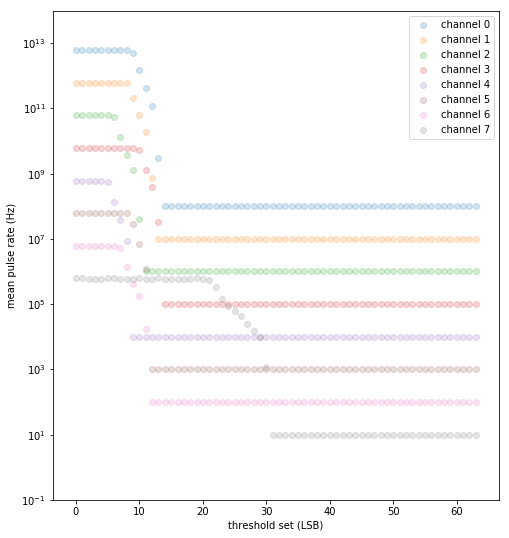

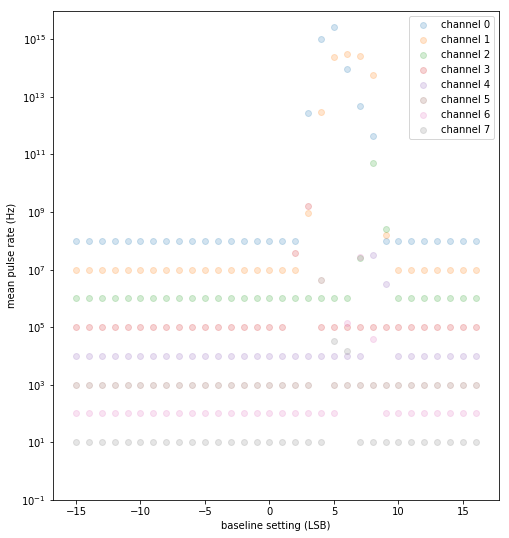

In [5]:
# staggerd plots:
plt.rcParams["figure.figsize"] = (8,9)
for i in range(0,8):
      nums = (np.array(tsbl_scan_raw[i])+1)*10**(8-i)
      plt.scatter(tsbl_range,nums,alpha=0.2,label = "channel {:d}".format(i))

      plt.legend()
      plt.xlabel("threshold set (LSB)")
      plt.ylabel("mean pulse rate (Hz)")
plt.yscale('log') 
plt.ylim(ymax = 1E14, ymin = 0.1)
plt.show()

plt.rcParams["figure.figsize"] = (8,9)
for i in range(0,8):
     nums = (np.array(noise_scan_raw[i])+1)*10**(8-i)
     plt.scatter(noise_range, nums,alpha=0.2,label = "channel {:d}".format(i))

     plt.legend()
     plt.xlabel("baseline setting (LSB)")
     plt.ylabel("mean pulse rate (Hz)")

plt.yscale('log') 
plt.ylim(ymax = 1E16, ymin = 0.1)
plt.show()


 baseline scans


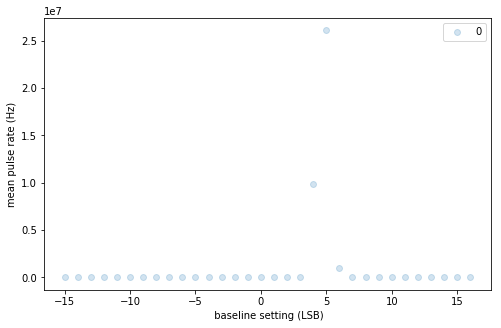

found baseline mean = 4.759989283801161+- 0.4944173628182145


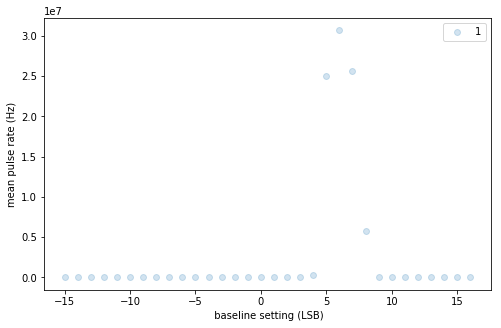

found baseline mean = 6.133189290835939+- 0.9167344999758981


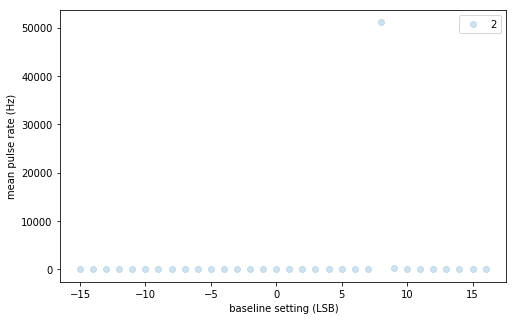

found baseline mean = 8.004379562043795+- 0.07303161979466515


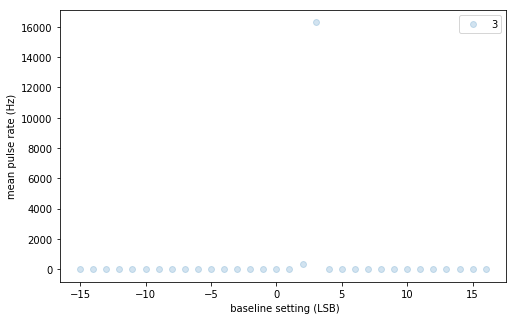

found baseline mean = 2.9772113943028486+- 0.1492289688617166


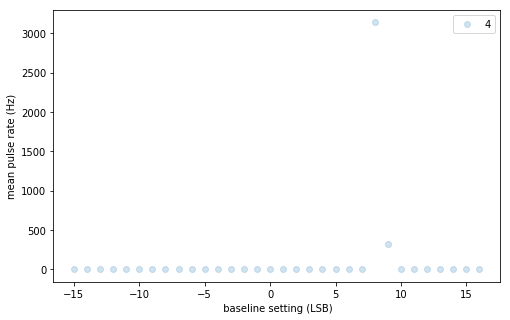

found baseline mean = 8.092485549132949+- 0.2897101522807322


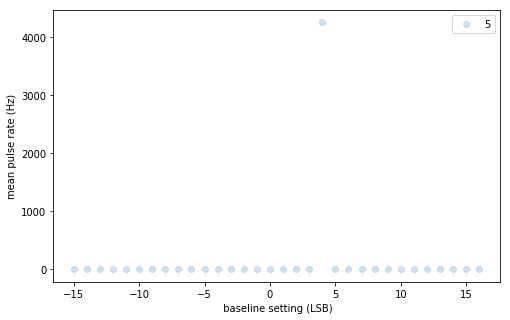

found baseline mean = 4.0+- 0.0


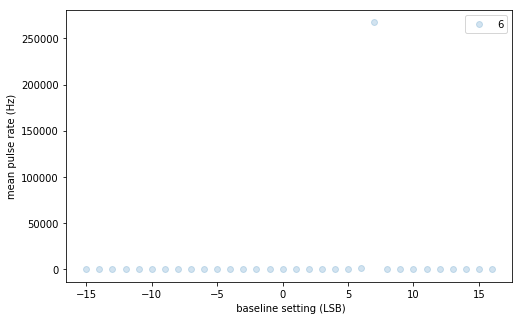

found baseline mean = 6.996375868862208+- 0.08022443873269565


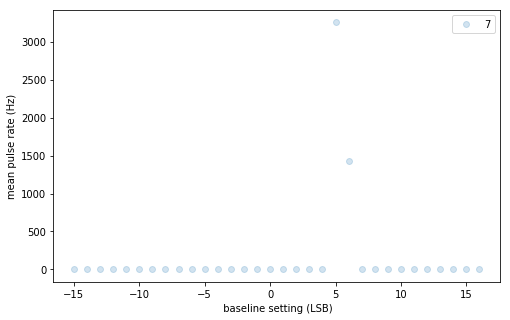

found baseline mean = 5.3059701492537314+- 0.4608171188436696


In [6]:
baseline_mean = [] 
baseline_stdev = [] 
#baselines plot:
print("\n baseline scans")
plt.rcParams["figure.figsize"] = (8,5)

def hist_rms(x,y):
  counts = np.sum(y)
  weights = y / counts
  mean = np.dot(x,weights)
  deviations = x - mean
  return np.sqrt(np.dot(deviations**2,weights))
def MeanArrays(xs,ys):
    return np.dot(xs,ys)/sum(ys)
        
for i in range(0,8):
       plt.scatter(noise_range,noise_scan_raw[i],alpha=0.2,label = "{:d}".format(i))

       plt.legend()
       plt.xlabel("  baseline setting (LSB) ")
       plt.ylabel("mean pulse rate (Hz)")
       #plt.yscale('log') 
       plt.show()
       found_bl_mean = MeanArrays(noise_range,noise_scan_raw[i]) #noise_range[np.array(noise_scan_raw[i]).argmax()]
       found_bl_stdev = hist_rms(noise_range,noise_scan_raw[i])    
       print("found baseline mean = "+ str(found_bl_mean)+ "+- "+ str(found_bl_stdev))
       baseline_mean += [found_bl_mean] 
       baseline_stdev += [found_bl_stdev] 


 threshold scans


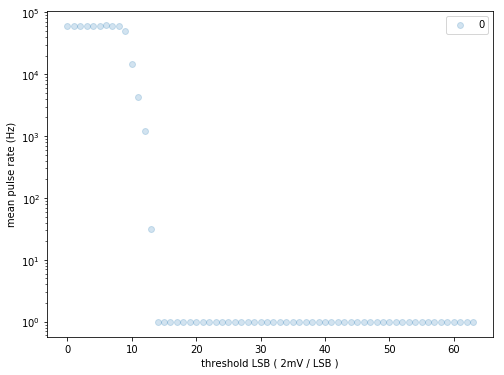

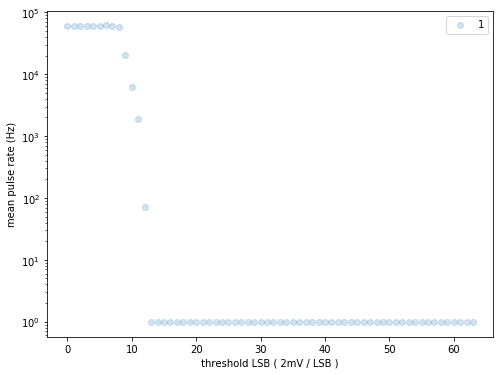

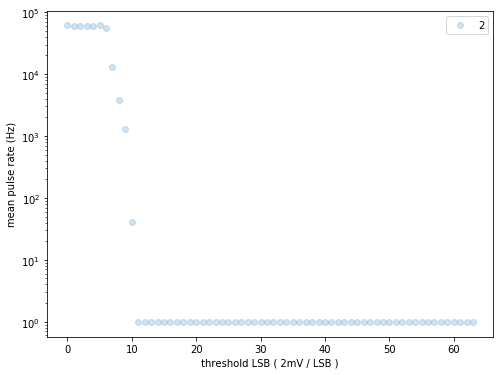

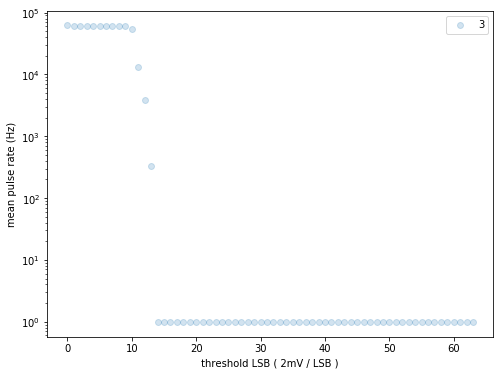

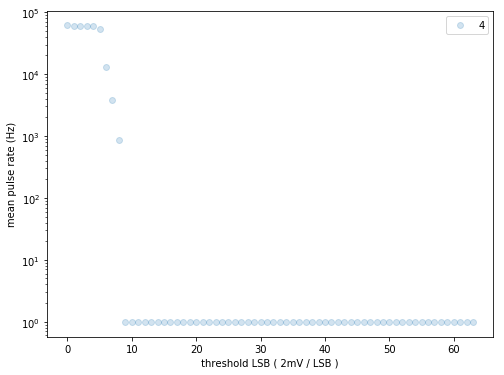

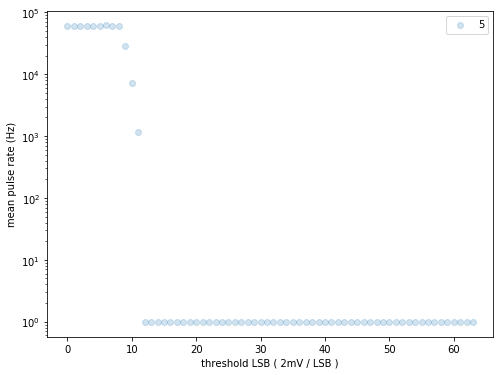

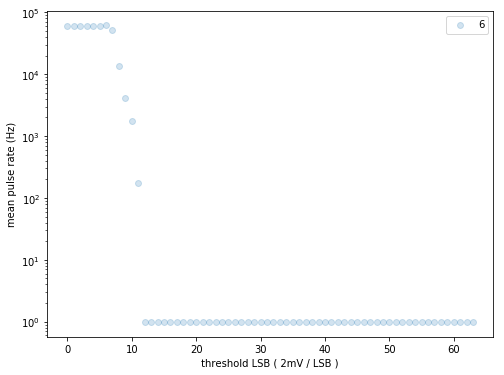

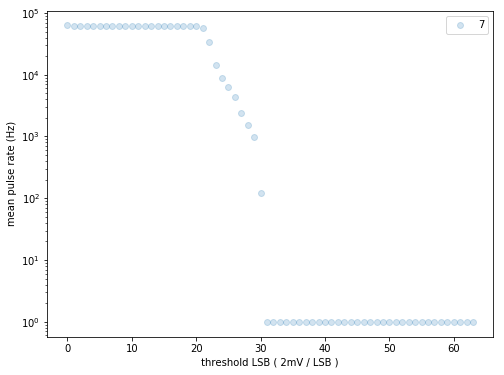

In [7]:
    
# threshold scan plots:
print("\n threshold scans")
plt.rcParams["figure.figsize"] = (8,6)
for i in range(0,8): 
      nums = np.array(tsbl_scan_raw[i])+1
      plt.scatter(tsbl_range,nums,alpha=0.2,label = "{:d}".format(i))

      plt.legend()
      plt.xlabel(" threshold LSB ( 2mV / LSB ) ")
      plt.ylabel("mean pulse rate (Hz)")
      plt.yscale('log') 
      plt.show()

root fitting


Info in <TCanvas::Print>: png file /workdir/data/pasttrec_quality/fit/PT_0001_noiseFit_channel000.png has been created
Info in <TCanvas::Print>: png file /workdir/data/pasttrec_quality/fit/PT_0001_noiseFit_channel001.png has been created
Info in <TCanvas::Print>: png file /workdir/data/pasttrec_quality/fit/PT_0001_noiseFit_channel002.png has been created
Info in <TCanvas::Print>: png file /workdir/data/pasttrec_quality/fit/PT_0001_noiseFit_channel003.png has been created
Info in <TCanvas::Print>: png file /workdir/data/pasttrec_quality/fit/PT_0001_noiseFit_channel004.png has been created
Info in <TCanvas::Print>: png file /workdir/data/pasttrec_quality/fit/PT_0001_noiseFit_channel005.png has been created
Info in <TCanvas::Print>: png file /workdir/data/pasttrec_quality/fit/PT_0001_noiseFit_channel006.png has been created
Info in <TCanvas::Print>: png file /workdir/data/pasttrec_quality/fit/PT_0001_noiseFit_channel007.png has been created


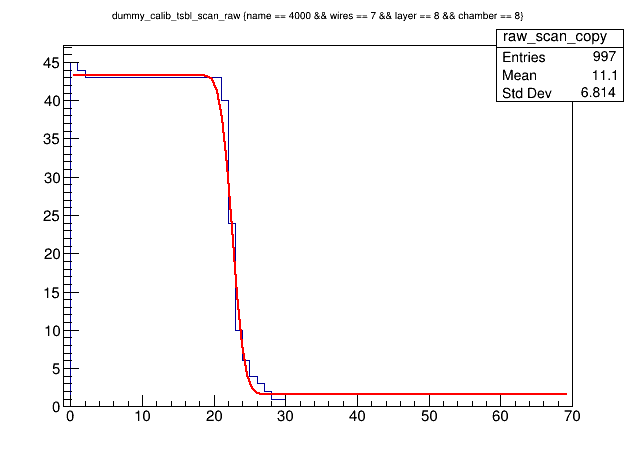

In [8]:
# analyse/fit results noise dpendence:
gif_out_list = []

import root_fit as fit
import os.path

# threshold scan scurve fit quality limit to store results
chisquare_limit = 50
n_channels = 8

#noise_plots = ["amplitude","half max","sigma","offset"]
#noise_plots_data = [[]*len(measure_board_list)]*2*len(noise_plots)
#noise_plots_data_x = []*len(measure_board_list)
noise_halfmax = []
noise_halfmax_err = [] 
noise_sigma = []
noise_sigma_err = []

# create fit directory
fit_dir = data_output_dicrectory + "/fit"
if not os.path.isdir(fit_dir):
        os.mkdir(fit_dir)
#clear older fit plots
#else:
#    os.system("rm -rf {:s}/*".format(fit_dir))
    
gif_out_list += [fit_dir]    
if os.path.isfile(root_name):
    print("root fitting")               
    f = ROOT.TFile(root_name)
    cscan = ROOT.TCanvas("cscan","The Canvas Title",640,480); cscan.cd();
    dummy_tsbl_tree = f.Get("dummy_tsbl_tree")
    for i in range(0,0+n_channels):
        
       #ndata = dummy_tsbl_tree.Draw("dummy_calib_tsbl_scan_raw>>raw_scan(33,0,30)","name == " + name  + " && wires == " + str(i)  )
       ndata = dummy_tsbl_tree.Draw("dummy_calib_tsbl_scan_raw>>raw_scan(71,-1,70)","name == " + str(name) + " && wires == " + str(i) + " && layer == 8 && chamber == 8"  )
       #ndata = dummy_tsbl_tree.Draw("dummy_calib_tsbl_scan_raw>>raw_scan(140,-10,130)","") 
        #"name == " + name   )         
       if (ndata > 0): 

               raw_scan = f.Get("raw_scan")
               
               results = fit.fit_scurve(raw_scan,0, chisquare_limit)
               raw_scan.DrawCopy()
               #cscan.SetLogy(1)
               cscan.Draw()
               cscan.Update()
               fit_picture_file = fit_dir+"/PT_"+serial+"_noiseFit_channel{:03d}".format(i) +".png"
               cscan.SaveAs(fit_picture_file)
               #noise_plots_data += [results]
               noise_halfmax += [results[2]]
               noise_halfmax_err += [results[3]] 
               noise_sigma += [results[4]]
               noise_sigma_err += [results[5]]                                       

animating graphics in /workdir/data/pasttrec_quality/fit
/workdir/data/pasttrec_quality/fit


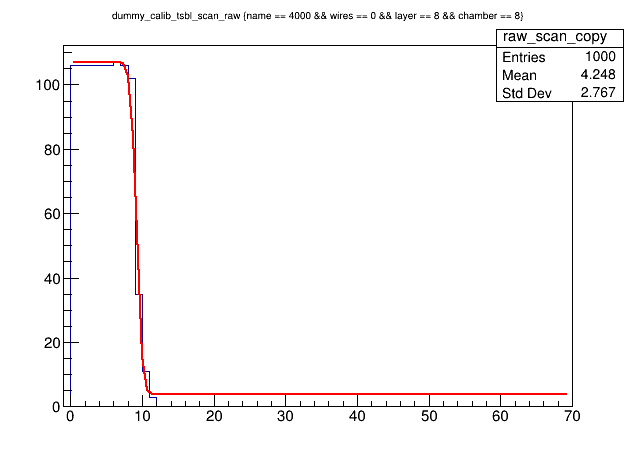

In [9]:
from IPython.display import Image
## display all single channel threshold scan fits into an animated gif
import os
# gif_out_list = ["/workdir/data/noise/fit/"]
for subfolder in sorted(list(set(gif_out_list))):
        print("animating graphics in {:s}".format(subfolder))
        print(subfolder)
        os.system("cd  {:s}; convert -alpha off -delay 100 -loop 0 *png output.gif ".format(subfolder))
        with open('{:s}/output.gif'.format(subfolder),'rb') as f:
            display(Image(data=f.read(), format='png'))

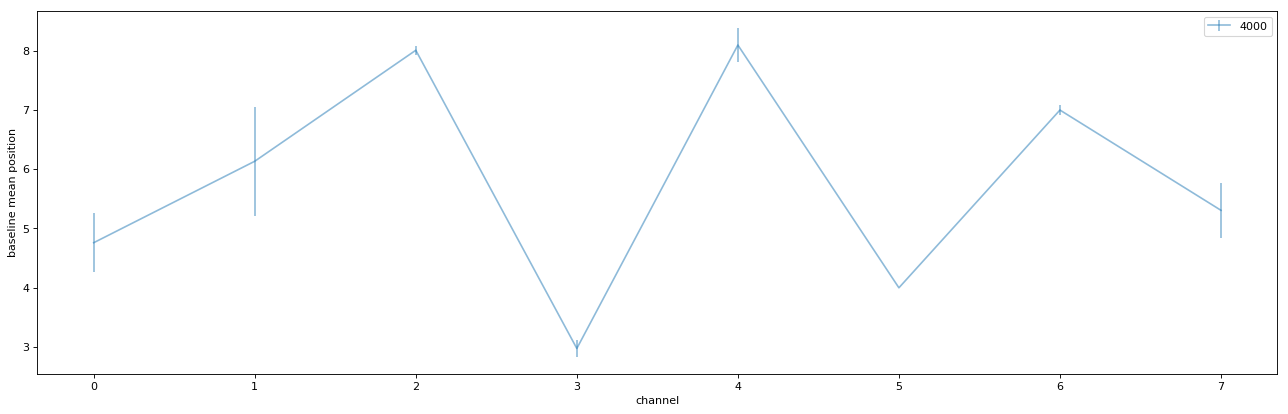

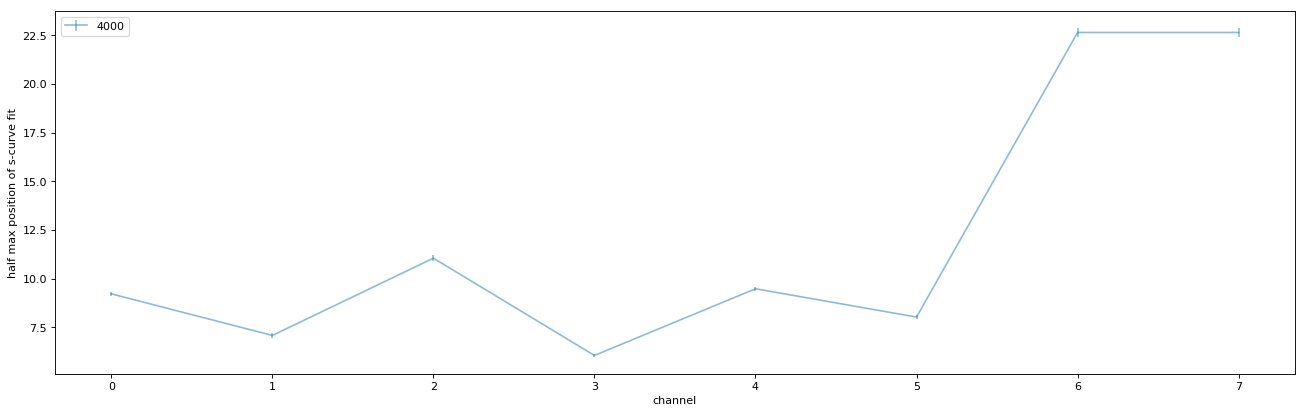

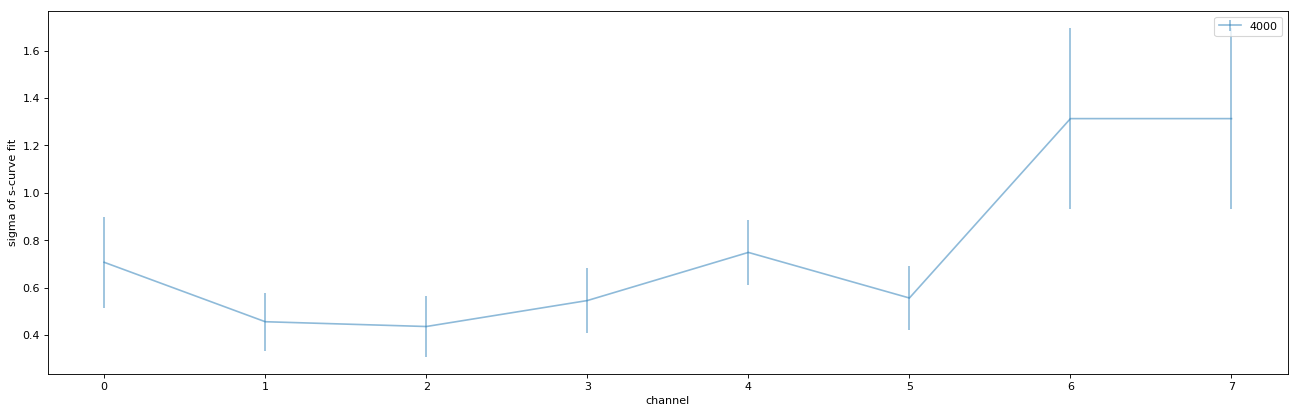

Baseline mean [LSB/2mV]:  [4.759989283801161, 6.133189290835939, 8.004379562043795, 2.9772113943028486, 8.092485549132949, 4.0, 6.996375868862208, 5.3059701492537314] | mean of 8 channels:  5.783700137279079  +- RMS =  1.7388504601156785
S-curve position (maximum half) [LSB/2mV]:  [9.226357692731069, 7.090383336164896, 11.058539711873767, 6.062272254691148, 9.48696531416402, 8.034038214870515, 22.650297805755244, 22.650297805755244] | mean of 8 channels:  12.032394017000739  +- RMS =  6.293189509533116
S-curve sigma [LSB/2mV]:  [0.7076684958693624, 0.457355078859506, 0.4371732267869244, 0.5465398531160626, 0.7493579949581997, 0.5572573224329691, 1.3130648906221787, 1.3130648906221787] | mean of 8 channels:  0.7601852191584226  +- RMS =  0.33486825992371616


In [10]:

# plot fit results for all 8 channels
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(data_output_dicrectory+"/"+"PT_"+serial+"_QAresults.pdf")



fig1 = plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(range(0,len(baseline_mean)),baseline_mean,baseline_stdev ,xerr=None, alpha=0.5,label = name)     
plt.xlabel("channel")
plt.ylabel("baseline mean position")
plt.legend()
plt.show()
pdf.savefig(fig1)

fig2 = plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(range(0,len(noise_halfmax)),noise_halfmax,noise_halfmax_err ,xerr=None, alpha=0.5,label = name)     
plt.xlabel("channel")
plt.ylabel("half max position of s-curve fit")
plt.legend()
plt.show()
pdf.savefig(fig2)

fig3 = plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(range(0,len(noise_sigma)),noise_sigma,noise_sigma_err ,xerr=None, alpha=0.5,label = name)     
plt.xlabel("channel")
plt.ylabel("sigma of s-curve fit")
plt.legend()
plt.show()
pdf.savefig(fig3)

pdf.close()
print("Baseline mean [LSB/2mV]: ",baseline_mean,"| mean of 8 channels: ", sum(baseline_mean)/len(baseline_mean), " +- RMS = ", list_rms(baseline_mean) ) 
print("S-curve position (maximum half) [LSB/2mV]: ",noise_halfmax,"| mean of 8 channels: ", sum(noise_halfmax)/len(noise_halfmax), " +- RMS = ", list_rms(noise_halfmax) )
print("S-curve sigma [LSB/2mV]: ",noise_sigma,"| mean of 8 channels: ", sum(noise_sigma)/len(noise_sigma), " +- RMS = ", list_rms(noise_sigma) )